In [1]:
# BiLSTM-based Intrusion Detection on TON IoT Dataset (Rewritten)

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split

# Load Dataset
df = pd.read_csv('../dataset/final_df.csv', low_memory=False)
print("Original DataFrame Head:\n", df.head())
print("\nOriginal Class Distribution:\n", df['type'].value_counts())
print("\nOriginal Label Distribution:\n", df['label'].value_counts())
print("\nOriginal Data Types:\n", df.dtypes)
print("\nOriginal Data Shapes:\n", df.shape)

# --- Data Preprocessing ---
# Clean and impute
df['src_bytes'] = pd.to_numeric(df['src_bytes'], errors='coerce').fillna(0)
df.drop_duplicates(inplace=True)

df.fillna(df.mean(numeric_only=True), inplace=True)
print(f"Shape after dropping duplicates: {df.shape}")

for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object':
            df[col].fillna('Missing', inplace=True) # Or df[col].mode()[0]
        else:
            df[col].fillna(df[col].mean(), inplace=True)

print(f"Shape after handling NaNs: {df.shape}")

# Identify targets
TARGET_LABEL = 'label'
TARGET_TYPE = 'type'

# Encode categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if TARGET_TYPE in categorical_cols:
    categorical_cols.remove(TARGET_TYPE)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded column: {col}")

# Normalize numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if TARGET_LABEL in numerical_cols:
    numerical_cols.remove(TARGET_LABEL)

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")


2025-09-07 18:51:18.904076: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-07 18:51:19.519233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-07 18:51:23.199169: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Original DataFrame Head:
            ts         src_ip  src_port        dst_ip  dst_port proto service  \
0  1556499101  192.168.1.193     60396  192.168.1.33      8080   tcp       -   
1  1556494424  192.168.1.193     59273  192.168.1.33      8080   tcp       -   
2  1556487945  192.168.1.193     57717  192.168.1.33      8080   tcp       -   
3  1556508616  192.168.1.193     62682  192.168.1.33        80   tcp       -   
4  1556511697  192.168.1.193     63419  192.168.1.33      8080   tcp       -   

   duration src_bytes  dst_bytes  ... http_response_body_len  \
0  0.000180         0          0  ...                      0   
1  0.000111         0          0  ...                      0   
2  0.000148         0          0  ...                      0   
3  0.000127         0          0  ...                      0   
4  0.000122         0          0  ...                      0   

   http_status_code  http_user_agent  http_orig_mime_types  \
0                 0                -          

In [2]:
binary_y = df[TARGET_LABEL].values
type_encoder = LabelEncoder()
y_multiclass_encoded = type_encoder.fit_transform(df[TARGET_TYPE])
num_classes = len(le.classes_)
# Convert to one-hot encoding for Keras if using categorical_crossentropy
y_multiclass_onehot = to_categorical(y_multiclass_encoded)

y_multiclass_labels = np.argmax(y_multiclass_onehot, axis=1)

# Drop targets from features
X = df.drop(columns=[TARGET_LABEL, TARGET_TYPE]).values
print("Feature shape (flat):", X.shape)
print("Binary target shape:", binary_y.shape)
print("Multi-class target shape:", y_multiclass_labels.shape)

# print the class distribution of binary_y and y_multiclass_labels
print("Binary target class distribution:")
print(Counter(binary_y))
print("Multi-class target class distribution:")
print(Counter(y_multiclass_labels))

Feature shape (flat): (441043, 44)
Binary target shape: (441043,)
Multi-class target shape: (441043,)
Binary target class distribution:
Counter({np.int64(0): 300000, np.int64(1): 141043})
Multi-class target class distribution:
Counter({np.int64(5): 300000, np.int64(0): 20000, np.int64(1): 20000, np.int64(2): 20000, np.int64(3): 20000, np.int64(6): 20000, np.int64(7): 20000, np.int64(8): 20000, np.int64(4): 1043})


In [3]:
# 1. Split BEFORE SMOTE (to avoid leakage)
# ----------------------------------------
X_train, X_test, y_train_multi, y_test_multi = train_test_split(
    X,
    y_multiclass_onehot,
    test_size=0.2,
    random_state=42,
    stratify=y_multiclass_encoded  # stratify on binary for this example
)

# Reset indices
X_train = pd.DataFrame(X_train).reset_index(drop=True).values
X_test = pd.DataFrame(X_test).reset_index(drop=True).values

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train_multiclass labels shape: {y_train_multi.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_test_multiclass labels shape: {y_test_multi.shape}")

# print the class distribution of binary_y and y_multiclass
# print the class distribution of binary_y and y_multiclass
print("Multi-class target class distribution (train):")
print(Counter(np.argmax(y_train_multi, axis=1)))
print("Multi-class target class distribution (test):")
print(Counter(np.argmax(y_test_multi, axis=1)))

# scaling the training data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Scaling complete.")


X_train shape: (352834, 44)
y_train_multiclass labels shape: (352834, 9)
X_test  shape: (88209, 44)
y_test_multiclass labels shape: (88209, 9)
Multi-class target class distribution (train):
Counter({np.int64(5): 240000, np.int64(0): 16000, np.int64(6): 16000, np.int64(7): 16000, np.int64(8): 16000, np.int64(2): 16000, np.int64(1): 16000, np.int64(3): 16000, np.int64(4): 834})
Multi-class target class distribution (test):
Counter({np.int64(5): 60000, np.int64(1): 4000, np.int64(3): 4000, np.int64(6): 4000, np.int64(0): 4000, np.int64(8): 4000, np.int64(7): 4000, np.int64(2): 4000, np.int64(4): 209})
Scaling complete.


In [4]:
# --- Create Sequences ---
def create_sequences(
    X,
    y,
    window_size: int = 10,
    debug: bool = False,
    trace_limit: int = 5
):
    # Convert to numpy if not already
    X = np.asarray(X)
    y = np.asarray(y)

    # Input validation
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples")
    if len(X.shape) != 2:
        raise ValueError("X must be a 2D array: (samples, features)")
    if len(y.shape) > 2:
        raise ValueError("y must be a 1D or 2D array")

    X_seq, y_seq = [], []
    total = len(X) - window_size + 1
    if debug:
        print(f"Total samples: {len(X)} | Generating {total} sequences (window_size={window_size})")

    for i in range(total):
        window = X[i : i + window_size]
        label = y[i + window_size - 1]
        X_seq.append(window)
        y_seq.append(label)

        if debug and i < trace_limit:
            print(f"\n--- Seq {i+1}/{total} ---")
            print(f"  X indices: {i} to {i+window_size-1}")
            print(f"  y index:   {i+window_size-1} → label={label}")
            print(f"  window.shape: {window.shape}")

    if debug:
        print(f"\nTotal sequences generated: {len(X_seq)}")

    return np.array(X_seq), np.array(y_seq)


TIMESTEPS = 20
X_train_seq, y_train_seq = create_sequences(X_train, y_train_multi, window_size=TIMESTEPS, debug=True)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_multi, window_size=TIMESTEPS, debug=True)


print("Train sequence shape:", X_train_seq.shape)  # (samples, timesteps, features)
print("Test sequence shape:", X_test_seq.shape)
print("multi target distribution:", Counter(np.argmax(y_train_multi, axis=1)))

# counters
print("Class distribution in y_train_seq:", Counter(np.argmax(y_train_seq, axis=1)))
print("Class distribution in y_test_seq:", Counter(np.argmax(y_test_seq, axis=1)))

# multiclass sequence generation.
# X_train_seq_multi, y_train_seq_multi = create_sequences(X_train, y_train_multi, debug=True)
# X_test_seq_multi, y_test_seq_multi = create_sequences(X_test, y_test_multi, debug=True)


Total samples: 352834 | Generating 352815 sequences (window_size=20)

--- Seq 1/352815 ---
  X indices: 0 to 19
  y index:   19 → label=[0. 0. 1. 0. 0. 0. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 2/352815 ---
  X indices: 1 to 20
  y index:   20 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 3/352815 ---
  X indices: 2 to 21
  y index:   21 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 4/352815 ---
  X indices: 3 to 22
  y index:   22 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 5/352815 ---
  X indices: 4 to 23
  y index:   23 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

Total sequences generated: 352815
Total samples: 88209 | Generating 88190 sequences (window_size=20)

--- Seq 1/88190 ---
  X indices: 0 to 19
  y index:   19 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 2/88190 ---
  X indices: 1 to 20
  y index:   20 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.

In [5]:
from sklearn.utils import shuffle

# X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_seq_bal, y_train_seq_bal, random_state=42)
X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_seq, y_train_seq, random_state=42)

val_fraction = 0.2
n_total = X_train_seq_bal_shuffle.shape[0]
n_val = int(n_total * val_fraction)

X_val_seq = X_train_seq_bal_shuffle[-n_val:]
y_val_seq = y_train_seq_bal_shuffle[-n_val:]
X_train_seq_final = X_train_seq_bal_shuffle[:-n_val]
y_train_seq_final = y_train_seq_bal_shuffle[:-n_val]

print("Final training shapes:")
print(f"X_train_seq_final shape: {X_train_seq_final.shape}")
print(f"y_train_seq_final shape: {y_train_seq_final.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")

print("Final training label distributions:")
print(f"y_train_seq_final distribution: {Counter(np.argmax(y_train_seq_final, axis=1))}")
print(f"y_val_seq distribution: {Counter(np.argmax(y_val_seq, axis=1))}")

Final training shapes:
X_train_seq_final shape: (282252, 20, 44)
y_train_seq_final shape: (282252, 9)
X_val_seq shape: (70563, 20, 44)
y_val_seq shape: (70563, 9)
Final training label distributions:
y_train_seq_final distribution: Counter({np.int64(5): 192120, np.int64(7): 12859, np.int64(2): 12851, np.int64(3): 12828, np.int64(6): 12792, np.int64(8): 12747, np.int64(0): 12710, np.int64(1): 12690, np.int64(4): 655})
y_val_seq distribution: Counter({np.int64(5): 47868, np.int64(1): 3310, np.int64(0): 3289, np.int64(8): 3252, np.int64(6): 3207, np.int64(3): 3172, np.int64(2): 3149, np.int64(7): 3138, np.int64(4): 178})


In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(y_multiclass_onehot.shape[1]),
    y=y_multiclass_onehot.argmax(axis=1)
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights for training:", class_weight_dict)

Class weights for training: {0: np.float64(2.450238888888889), 1: np.float64(2.450238888888889), 2: np.float64(2.450238888888889), 3: np.float64(2.450238888888889), 4: np.float64(46.984446575050605), 5: np.float64(0.16334925925925925), 6: np.float64(2.450238888888889), 7: np.float64(2.450238888888889), 8: np.float64(2.450238888888889)}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, AUC
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score, classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

# Model definition
model = Sequential([
    Bidirectional(LSTM(
        128, 
        return_sequences=True,  # Only final output
        recurrent_dropout=0.2,
        recurrent_activation='sigmoid',
        activation='tanh'
    ),
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])),
    LayerNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    LayerNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
])
model.summary()

optimizer = Adam(
    learning_rate=0.0001,  # Very low initial LR
    clipnorm=1.0,  # Gradient clipping to prevent exploding gradients
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Recall(name='recall'),
        Precision(name='precision')
    ]
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,        # Key Change: Much lower patience
    mode='min',
    restore_best_weights=True, # This is correct and crucial
    verbose=1
)

# Reduce learning rate after 2 epochs of no improvement
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,        # Usually, LR reduction has a lower patience than early stopping
    min_lr=1e-6,
    verbose=1
)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(y_multiclass_onehot.shape[1]),
    y=y_multiclass_onehot.argmax(axis=1)
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights for training:", class_weight_dict)

# Train
history = model.fit(
    X_train_seq_final, y_train_seq_final,
    validation_data=(X_val_seq, y_val_seq),
    epochs=10,
    batch_size=64,
    shuffle=False,  # Important for time series
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

results = model.evaluate(X_test_seq, y_test_seq, verbose=2)

print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {}".format(results[1]))


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 20, 256)        │       177,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 20, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,113 (1.34 MB)

 Trainable params: 351,113 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Class weights for training: {0: np.float64(2.450238888888889), 1: np.float64(2.450238888888889), 2: np.float64(2.450238888888889), 3: np.float64(2.450238888888889), 4: np.float64(46.984446575050605), 5: np.float64(0.16334925925925925), 6: np.float64(2.450238888888889), 7: np.float64(2.450238888888889), 8: np.float64(2.450238888888889)}
Epoch 1/10
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 172s 38ms/step - accuracy: 0.5798 - auc: 0.9153 - loss: 1.2795 - precision: 0.7703 - recall: 0.4547 - val_accuracy: 0.7581 - val_auc: 0.9653 - val_loss: 0.7245 - val_precision: 0.8327 - val_recall: 0.6889 - learning_rate: 1.0000e-04
Epoch 2/10
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 167s 38ms/step - accuracy: 0.8094 - auc: 0.9751 - loss: 0.6745 - precision: 0.8570 - recall: 0.7689 - val_accuracy: 0.8910 - val_auc: 0.9866 - val_loss: 0.3995 - val_precision: 0.9063 - val_recall: 0.8806 - learning_rate: 1.0000e-04
Epoch 3/10
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 167s 38ms/step - accuracy: 0.8733 - auc: 0.9864 - loss: 0.4232 - preci

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3997
           1       0.92      0.98      0.95      3998
           2       0.93      0.97      0.95      4000
           3       0.92      0.98      0.95      3999
           4       0.25      0.98      0.40       209
           5       1.00      0.97      0.98     59991
           6       0.95      1.00      0.97      3998
           7       0.95      1.00      0.97      3999
           8       0.94      0.99      0.97      3999

    accuracy                           0.97     88190
   macro avg       0.87      0.98      0.90     88190
weighted avg       0.98      0.97      0.97     88190

[[ 3997     0     0     0     0     0     0     0     0]
 [    0  3917     0    64     0     8     8     0     1]
 [    0     0  3868    13     0   119     0     0     0]
 [    0    11    65  3919     0     3     0     0     1]
 [    0     0     0   

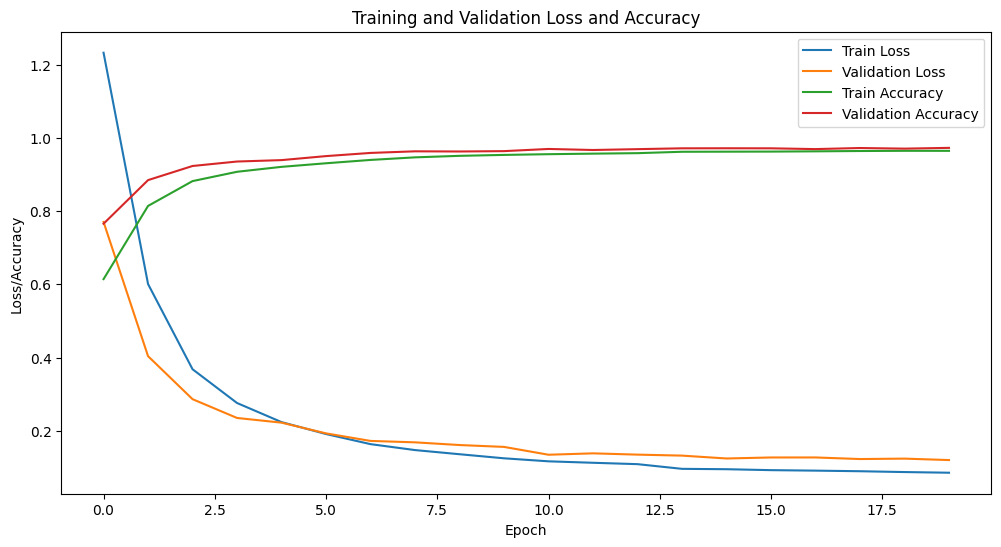

In [11]:

# Print classification report
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq.argmax(axis=1)
print(classification_report(y_true_classes, y_pred_classes))

#confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)

# For multi-class, FNR and FPR are not simply tn, fp, fn, tp.
# If you want per-class FNR/FPR:
fnr = []
fpr = []
for i in range(cm.shape[0]):
    fn = cm[i, :].sum() - cm[i, i]
    tp = cm[i, i]
    fp = cm[:, i].sum() - cm[i, i]
    tn = cm.sum() - (tp + fn + fp)
    fnr.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
print("False Negative Rate (FNR) per class:", fnr)
print("False Positive Rate (FPR) per class:", fpr)

# plot validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()


In [8]:
# Hyperparameter Tuning with Bayesian Optimization (BayesSearchCV)
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold

def build_bilstm_model(
    lstm_units=64,
    hidden_layer=32,
    dropout=0.2,
    learning_rate=0.001,
    input_shape=(30, 44)
):
    model = Sequential([
        Bidirectional(LSTM(int(lstm_units*2), return_sequences=True, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2), input_shape=input_shape),
        LayerNormalization(),
        Dropout(dropout),
        Bidirectional(LSTM(int(lstm_units))),
        LayerNormalization(),
        Dropout(dropout),
        Dense(int(hidden_layer), activation='relu'),
        Dense(9, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

from sklearn.metrics import make_scorer

def constrained_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = accuracy_score(y_true, y_pred)
        # Constraints: FNR ≤ 0.01, FPR ≤ 0.5, Accuracy > 0.90
        if fnr <= 0.01 and fpr <= 0.5 and acc > 0.90:
            print(f"Valid model found: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return acc
        else:
            print(f"Model rejected: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return 0
    else:
        # If confusion matrix is not 2x2, return 0
        return 0

constrained_scorer = make_scorer(constrained_score)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(y_multiclass_onehot.shape[1]),
    y=y_multiclass_onehot.argmax(axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

# Wrap the model for scikit-learn compatibility
keras_clf = KerasClassifier(
    model=build_bilstm_model,
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])
)

# Define the hyperparameter search space
param_space = {
    'model__lstm_units': Integer(64, 128),
    'model__hidden_layer': Integer(16, 32),
    'model__dropout': Real(0.2, 0.4),
    'model__learning_rate': Real(1e-4, 1e-2, prior='log-uniform'),
    'batch_size': Categorical([64, 128]),
    'epochs': Integer(5, 10)
}

opt = BayesSearchCV(
    estimator=keras_clf,
    search_spaces=param_space,
    n_iter=1,
    # scoring=constrained_scorer,
    scoring="accuracy",
    # cv=2,
    cv=cv_strategy,
    n_jobs=1,
    verbose=2,
    refit=True
)

# Convert one-hot encoded targets to integer labels
y_train_seq_final_labels = np.argmax(y_train_seq_final, axis=1)
y_test_seq_labels = np.argmax(y_test_seq, axis=1)

# Fit the optimizer (this may take a while)
opt.fit(X_train_seq_final, y_train_seq_final_labels, callbacks=[early_stopping, reduce_lr], validation_split=0.2, class_weight=class_weight_dict)

print('Best parameters:', opt.best_params_)
print('Best cross-validation accuracy:', opt.best_score_)

# Evaluate on test set
test_score = opt.score(X_test_seq, y_test_seq_labels)
print('Test set accuracy:', test_score)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 96s 39ms/step - accuracy: 0.6878 - loss: 1.0319 - val_accuracy: 0.8767 - val_loss: 0.4188
Epoch 2/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.8616 - loss: 0.4961 - val_accuracy: 0.9118 - val_loss: 0.2991
Epoch 3/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.8879 - loss: 0.3651 - val_accuracy: 0.9275 - val_loss: 0.2640
Epoch 4/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.8983 - loss: 0.3220 - val_accuracy: 0.9131 - val_loss: 0.2459
Epoch 5/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9072 - loss: 0.3039 - val_accuracy: 0.9251 - val_loss: 0.2620
Epoch 6/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9151 - loss: 0.2812 - val_accuracy: 0.8948 - val_loss: 0.3931
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
[CV] END batch_size=64, epochs=6, model__dropout=0.3521748593566639, model__hidden_layer=22, model__learning_rate=0.0012576639417933484, model__lstm_units=65; total time

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.1601 - loss: 2.1803 - val_accuracy: 0.0466 - val_loss: 2.1846
Epoch 2/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.0824 - loss: 2.1776 - val_accuracy: 0.0453 - val_loss: 2.1785
Epoch 3/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.2172 - loss: 1.8767 - val_accuracy: 0.7046 - val_loss: 0.7559
Epoch 4/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.7574 - loss: 0.8115 - val_accuracy: 0.8675 - val_loss: 0.4478
Epoch 5/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.8482 - loss: 0.5280 - val_accuracy: 0.9082 - val_loss: 0.3312
Epoch 6/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.8700 - loss: 0.4343 - val_accuracy: 0.8081 - val_loss: 0.4091
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
[CV] END batch_size=64, epochs=6, model__dropout=0.3521748593566639, model__hidden_layer=22, model__learning_rate=0.0012576639417933484, model__lstm_units=65; total time

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 91s 37ms/step - accuracy: 0.5683 - loss: 1.2136 - val_accuracy: 0.8763 - val_loss: 0.4300
Epoch 2/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.8625 - loss: 0.5208 - val_accuracy: 0.9207 - val_loss: 0.3141
Epoch 3/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.8879 - loss: 0.4050 - val_accuracy: 0.9095 - val_loss: 0.3221
Epoch 4/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9003 - loss: 0.3366 - val_accuracy: 0.8944 - val_loss: 0.3475
Epoch 5/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9067 - loss: 0.3310 - val_accuracy: 0.9080 - val_loss: 0.3088
Epoch 6/6
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9113 - loss: 0.3072 - val_accuracy: 0.9259 - val_loss: 0.2455
1471/1471 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
[CV] END batch_size=64, epochs=6, model__dropout=0.3521748593566639, model__hidden_layer=22, model__learning_rate=0.0012576639417933484, model__lstm_units=65; total time

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 134s 37ms/step - accuracy: 0.5811 - loss: 1.1523 - val_accuracy: 0.8993 - val_loss: 0.3923
Epoch 2/6
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 130s 37ms/step - accuracy: 0.8704 - loss: 0.4410 - val_accuracy: 0.9179 - val_loss: 0.2875
Epoch 3/6
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 130s 37ms/step - accuracy: 0.8958 - loss: 0.3281 - val_accuracy: 0.9298 - val_loss: 0.2360
Epoch 4/6
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 130s 37ms/step - accuracy: 0.9048 - loss: 0.3184 - val_accuracy: 0.9399 - val_loss: 0.2349
Epoch 5/6
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 130s 37ms/step - accuracy: 0.9113 - loss: 0.3047 - val_accuracy: 0.9363 - val_loss: 0.2090
Epoch 6/6
3529/3529 ━━━━━━━━━━━━━━━━━━━━ 130s 37ms/step - accuracy: 0.9151 - loss: 0.2991 - val_accuracy: 0.9074 - val_loss: 0.2770
Best parameters: OrderedDict({'batch_size': 64, 'epochs': 6, 'model__dropout': 0.3521748593566639, 'model__hidden_layer': 22, 'model__learning_rate': 0.0012576639417933484, 'model__lstm_units': 65})
Best cros

In [9]:
# Hyperparameter Tuning with Bayesian Optimization (BayesSearchCV)
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold

def build_bilstm_model(
    lstm_units=64,
    hidden_layer=32,
    dropout=0.2,
    learning_rate=0.001,
    input_shape=(30, 44)
):
    model = Sequential([
        Bidirectional(LSTM(int(lstm_units*2), return_sequences=True, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2), input_shape=input_shape),
        LayerNormalization(),
        Dropout(dropout),
        Bidirectional(LSTM(int(lstm_units))),
        LayerNormalization(),
        Dropout(dropout),
        Dense(int(hidden_layer), activation='relu'),
        Dense(9, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

from sklearn.metrics import make_scorer

def constrained_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = accuracy_score(y_true, y_pred)
        # Constraints: FNR ≤ 0.01, FPR ≤ 0.5, Accuracy > 0.90
        if fnr <= 0.01 and fpr <= 0.5 and acc > 0.90:
            print(f"Valid model found: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return acc
        else:
            print(f"Model rejected: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return 0
    else:
        # If confusion matrix is not 2x2, return 0
        return 0

constrained_scorer = make_scorer(constrained_score)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(y_multiclass_onehot.shape[1]),
    y=y_multiclass_onehot.argmax(axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

# Wrap the model for scikit-learn compatibility
keras_clf = KerasClassifier(
    model=build_bilstm_model,
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])
)

# Define the hyperparameter search space
param_space = {
    'model__lstm_units': Integer(64, 128),
    'model__hidden_layer': Integer(16, 32),
    'model__dropout': Real(0.2, 0.4),
    'model__learning_rate': Real(1e-4, 1e-2, prior='log-uniform'),
    'batch_size': Categorical([64, 128]),
    'epochs': Integer(5, 10)
}

opt = BayesSearchCV(
    estimator=keras_clf,
    search_spaces=param_space,
    n_iter=10,
    # scoring=constrained_scorer,
    scoring="accuracy",
    # cv=2,
    cv=cv_strategy,
    n_jobs=1,
    verbose=2,
    refit=True
)

# Convert one-hot encoded targets to integer labels
y_train_seq_final_labels = np.argmax(y_train_seq_final, axis=1)
y_test_seq_labels = np.argmax(y_test_seq, axis=1)

# Fit the optimizer (this may take a while)
opt.fit(X_train_seq_final, y_train_seq_final_labels, callbacks=[early_stopping, reduce_lr], validation_split=0.2, class_weight=class_weight_dict)

print('Best parameters:', opt.best_params_)
print('Best cross-validation accuracy:', opt.best_score_)

# Evaluate on test set
test_score = opt.score(X_test_seq, y_test_seq_labels)
print('Test set accuracy:', test_score)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 107s 44ms/step - accuracy: 0.1043 - loss: 2.1356 - val_accuracy: 0.3379 - val_loss: 1.3604
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.6444 - loss: 1.0444 - val_accuracy: 0.8380 - val_loss: 0.5456
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.8324 - loss: 0.6686 - val_accuracy: 0.8610 - val_loss: 0.4242
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.8529 - loss: 0.5960 - val_accuracy: 0.8700 - val_loss: 0.4189
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.8638 - loss: 0.5439 - val_accuracy: 0.9153 - val_loss: 0.3506
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.8699 - loss: 0.5238 - val_accuracy: 0.9240 - val_loss: 0.3141
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.8765 - loss: 0.5314 - val_accuracy: 0.9256 - val_loss: 0.3271
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 100s 43ms/step - accuracy: 0.8807 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 104s 43ms/step - accuracy: 0.0855 - loss: 2.1817 - val_accuracy: 0.0466 - val_loss: 2.1803
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 99s 42ms/step - accuracy: 0.0624 - loss: 2.1783 - val_accuracy: 0.0461 - val_loss: 2.1869
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 99s 42ms/step - accuracy: 0.0911 - loss: 2.1785 - val_accuracy: 0.0466 - val_loss: 2.1954
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 99s 42ms/step - accuracy: 0.0664 - loss: 2.1780 - val_accuracy: 0.0457 - val_loss: 2.1962
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 99s 42ms/step - accuracy: 0.0852 - loss: 2.1781 - val_accuracy: 0.0457 - val_loss: 2.1999
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 99s 42ms/step - accuracy: 0.0430 - loss: 2.1781 - val_accuracy: 0.0457 - val_loss: 2.1949
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 99s 42ms/step - accuracy: 0.0628 - loss: 2.1780 - val_accuracy: 0.6766 - val_loss: 2.1662
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 98s 42ms/step - accuracy: 0.0714 - loss: 

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 41ms/step - accuracy: 0.0951 - loss: 2.2679 - val_accuracy: 0.0458 - val_loss: 2.1884
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 97s 41ms/step - accuracy: 0.1285 - loss: 2.2954 - val_accuracy: 0.6770 - val_loss: 2.0106
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 97s 41ms/step - accuracy: 0.1434 - loss: 2.3935 - val_accuracy: 0.0444 - val_loss: 2.1582
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 97s 41ms/step - accuracy: 0.1649 - loss: 2.4051 - val_accuracy: 0.4559 - val_loss: 1.7156
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 97s 41ms/step - accuracy: 0.3659 - loss: 1.8143 - val_accuracy: 0.5057 - val_loss: 1.0415
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 97s 41ms/step - accuracy: 0.7026 - loss: 1.3978 - val_accuracy: 0.8045 - val_loss: 0.6175
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 97s 41ms/step - accuracy: 0.8086 - loss: 1.0403 - val_accuracy: 0.8890 - val_loss: 0.3384
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 97s 41ms/step - accuracy: 0.8450 - loss: 

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 62s 49ms/step - accuracy: 0.1630 - loss: 2.1798 - val_accuracy: 0.0469 - val_loss: 2.1791
Epoch 2/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.0612 - loss: 2.1738 - val_accuracy: 0.6773 - val_loss: 2.1855
Epoch 3/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.1063 - loss: 2.1722 - val_accuracy: 0.0461 - val_loss: 2.1922
Epoch 4/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step - accuracy: 0.0802 - loss: 2.1722 - val_accuracy: 0.0469 - val_loss: 2.1768
Epoch 5/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.0680 - loss: 2.1723 - val_accuracy: 0.0455 - val_loss: 2.1660
Epoch 6/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.0755 - loss: 2.1722 - val_accuracy: 0.0447 - val_loss: 2.1862
736/736 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step
[CV] END batch_size=128, epochs=6, model__dropout=0.38551840375881824, model__hidden_layer=24, model__learning_rate=0.003851666251035655, model__lstm_units=113; total time

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.0989 - loss: 2.1844 - val_accuracy: 0.6766 - val_loss: 2.1748
Epoch 2/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.0821 - loss: 2.1793 - val_accuracy: 0.0453 - val_loss: 2.1909
Epoch 3/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.0956 - loss: 2.1777 - val_accuracy: 0.0027 - val_loss: 2.2001
Epoch 4/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.0470 - loss: 2.1776 - val_accuracy: 0.0461 - val_loss: 2.1750
Epoch 5/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.1264 - loss: 2.1778 - val_accuracy: 0.0453 - val_loss: 2.1925
Epoch 6/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.1160 - loss: 2.1780 - val_accuracy: 0.0466 - val_loss: 2.2045
736/736 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step
[CV] END batch_size=128, epochs=6, model__dropout=0.38551840375881824, model__hidden_layer=24, model__learning_rate=0.003851666251035655, model__lstm_units=113; total time

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 61s 49ms/step - accuracy: 0.0572 - loss: 2.1777 - val_accuracy: 0.0470 - val_loss: 2.1952
Epoch 2/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step - accuracy: 0.0766 - loss: 2.1766 - val_accuracy: 0.0461 - val_loss: 2.1751
Epoch 3/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step - accuracy: 0.1111 - loss: 2.1765 - val_accuracy: 0.0444 - val_loss: 2.1752
Epoch 4/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step - accuracy: 0.0480 - loss: 2.1761 - val_accuracy: 0.0459 - val_loss: 2.2018
Epoch 5/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step - accuracy: 0.0944 - loss: 2.1764 - val_accuracy: 0.0461 - val_loss: 2.2005
Epoch 6/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step - accuracy: 0.0908 - loss: 2.1764 - val_accuracy: 0.0461 - val_loss: 2.1865
736/736 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step
[CV] END batch_size=128, epochs=6, model__dropout=0.38551840375881824, model__hidden_layer=24, model__learning_rate=0.003851666251035655, model__lstm_units=113; total time

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 108s 44ms/step - accuracy: 0.0810 - loss: 2.1748 - val_accuracy: 0.0455 - val_loss: 2.1783
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.0626 - loss: 2.1731 - val_accuracy: 0.0447 - val_loss: 2.2021
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.1240 - loss: 2.1733 - val_accuracy: 0.0467 - val_loss: 2.2052
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.0575 - loss: 2.1728 - val_accuracy: 0.0469 - val_loss: 2.1656
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.0736 - loss: 2.1729 - val_accuracy: 0.0447 - val_loss: 2.1742
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.0585 - loss: 2.1733 - val_accuracy: 0.0455 - val_loss: 2.1867
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.1075 - loss: 2.1729 - val_accuracy: 0.0455 - val_loss: 2.1638
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.0488 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 106s 44ms/step - accuracy: 0.0855 - loss: 2.1880 - val_accuracy: 0.0461 - val_loss: 2.1747
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.0911 - loss: 2.1798 - val_accuracy: 0.0457 - val_loss: 2.1329
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.0904 - loss: 2.1789 - val_accuracy: 0.0453 - val_loss: 2.1955
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.0546 - loss: 2.1789 - val_accuracy: 0.0453 - val_loss: 2.1706
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 44ms/step - accuracy: 0.0669 - loss: 2.1794 - val_accuracy: 0.0457 - val_loss: 2.1658
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 44ms/step - accuracy: 0.0931 - loss: 2.1786 - val_accuracy: 0.0453 - val_loss: 2.1893
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 44ms/step - accuracy: 0.0810 - loss: 2.1790 - val_accuracy: 0.0457 - val_loss: 2.1504
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.0562 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 106s 44ms/step - accuracy: 0.0915 - loss: 2.2691 - val_accuracy: 0.0468 - val_loss: 2.2443
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.1500 - loss: 2.3961 - val_accuracy: 0.0458 - val_loss: 2.2935
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.1465 - loss: 2.5633 - val_accuracy: 0.0470 - val_loss: 2.2217
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 44ms/step - accuracy: 0.1281 - loss: 2.6407 - val_accuracy: 0.0470 - val_loss: 2.3408
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 44ms/step - accuracy: 0.1240 - loss: 2.7047 - val_accuracy: 0.0444 - val_loss: 2.4832
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 44ms/step - accuracy: 0.1223 - loss: 2.8392 - val_accuracy: 0.0444 - val_loss: 2.2484
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.1142 - loss: 2.8983 - val_accuracy: 0.6770 - val_loss: 1.8513
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.1121 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 44ms/step - accuracy: 0.0590 - loss: 2.1770 - val_accuracy: 0.0447 - val_loss: 2.2132
Epoch 2/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0758 - loss: 2.1731 - val_accuracy: 0.0467 - val_loss: 2.1833
Epoch 3/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0799 - loss: 2.1731 - val_accuracy: 0.0455 - val_loss: 2.1713
Epoch 4/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0896 - loss: 2.1726 - val_accuracy: 0.0469 - val_loss: 2.2066
Epoch 5/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0564 - loss: 2.1729 - val_accuracy: 0.0447 - val_loss: 2.1501
Epoch 6/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0509 - loss: 2.1726 - val_accuracy: 0.0454 - val_loss: 2.2171
Epoch 7/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0832 - loss: 2.1724 - val_accuracy: 0.0029 - val_loss: 2.1941
Epoch 8/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0987 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.1039 - loss: 2.1809 - val_accuracy: 0.0027 - val_loss: 2.2234
Epoch 2/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0438 - loss: 2.1786 - val_accuracy: 0.0457 - val_loss: 2.1728
Epoch 3/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0684 - loss: 2.1786 - val_accuracy: 0.0461 - val_loss: 2.1872
Epoch 4/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0887 - loss: 2.1789 - val_accuracy: 0.0027 - val_loss: 2.2162
Epoch 5/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0603 - loss: 2.1794 - val_accuracy: 0.0457 - val_loss: 2.1776
Epoch 6/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0772 - loss: 2.1790 - val_accuracy: 0.0466 - val_loss: 2.1575
Epoch 7/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0616 - loss: 2.1785 - val_accuracy: 0.0453 - val_loss: 2.2194
Epoch 8/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0629 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - accuracy: 0.0598 - loss: 2.1819 - val_accuracy: 0.0444 - val_loss: 2.2027
Epoch 2/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0984 - loss: 2.1773 - val_accuracy: 0.0458 - val_loss: 2.2192
Epoch 3/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0769 - loss: 2.1772 - val_accuracy: 0.0468 - val_loss: 2.1777
Epoch 4/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0457 - loss: 2.1771 - val_accuracy: 0.0458 - val_loss: 2.1853
Epoch 5/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0735 - loss: 2.1772 - val_accuracy: 0.0444 - val_loss: 2.1461
Epoch 6/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0472 - loss: 2.1772 - val_accuracy: 0.0461 - val_loss: 2.1643
Epoch 7/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0696 - loss: 2.1771 - val_accuracy: 0.0468 - val_loss: 2.2108
Epoch 8/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.0562 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - accuracy: 0.5349 - loss: 1.3042 - val_accuracy: 0.8295 - val_loss: 0.6259
Epoch 2/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.8404 - loss: 0.5136 - val_accuracy: 0.9024 - val_loss: 0.3821
Epoch 3/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.8882 - loss: 0.3486 - val_accuracy: 0.8999 - val_loss: 0.3171
Epoch 4/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9074 - loss: 0.2770 - val_accuracy: 0.9342 - val_loss: 0.2368
Epoch 5/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9186 - loss: 0.2384 - val_accuracy: 0.9299 - val_loss: 0.2653
Epoch 6/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9272 - loss: 0.2044 - val_accuracy: 0.9427 - val_loss: 0.2267
736/736 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
[CV] END batch_size=128, epochs=6, model__dropout=0.2863661696474195, model__hidden_layer=30, model__learning_rate=0.0005532304540792943, model__lstm_units=97; total time=

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 57s 45ms/step - accuracy: 0.5053 - loss: 1.4117 - val_accuracy: 0.7992 - val_loss: 0.6671
Epoch 2/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.8358 - loss: 0.5570 - val_accuracy: 0.8978 - val_loss: 0.3589
Epoch 3/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.8915 - loss: 0.3360 - val_accuracy: 0.9056 - val_loss: 0.2912
Epoch 4/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9120 - loss: 0.2625 - val_accuracy: 0.9403 - val_loss: 0.2220
Epoch 5/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9248 - loss: 0.2176 - val_accuracy: 0.9408 - val_loss: 0.2103
Epoch 6/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9322 - loss: 0.1841 - val_accuracy: 0.9476 - val_loss: 0.2019
736/736 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
[CV] END batch_size=128, epochs=6, model__dropout=0.2863661696474195, model__hidden_layer=30, model__learning_rate=0.0005532304540792943, model__lstm_units=97; total time=

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 57s 46ms/step - accuracy: 0.5990 - loss: 1.1578 - val_accuracy: 0.8328 - val_loss: 0.5246
Epoch 2/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.8348 - loss: 0.5142 - val_accuracy: 0.8954 - val_loss: 0.3648
Epoch 3/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.8850 - loss: 0.3323 - val_accuracy: 0.9126 - val_loss: 0.2885
Epoch 4/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9036 - loss: 0.2731 - val_accuracy: 0.9274 - val_loss: 0.2434
Epoch 5/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9140 - loss: 0.2332 - val_accuracy: 0.9100 - val_loss: 0.2799
Epoch 6/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9236 - loss: 0.1958 - val_accuracy: 0.9483 - val_loss: 0.1945
736/736 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
[CV] END batch_size=128, epochs=6, model__dropout=0.2863661696474195, model__hidden_layer=30, model__learning_rate=0.0005532304540792943, model__lstm_units=97; total time=

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.6027 - loss: 1.2016 - val_accuracy: 0.8854 - val_loss: 0.4267
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.8706 - loss: 0.4946 - val_accuracy: 0.8867 - val_loss: 0.3423
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.8944 - loss: 0.3581 - val_accuracy: 0.9137 - val_loss: 0.3002
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9100 - loss: 0.3015 - val_accuracy: 0.9402 - val_loss: 0.2232
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9158 - loss: 0.2780 - val_accuracy: 0.9319 - val_loss: 0.2285
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9203 - loss: 0.2693 - val_accuracy: 0.9417 - val_loss: 0.2030
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9238 - loss: 0.2675 - val_accuracy: 0.9395 - val_loss: 0.1939
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9247 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 91s 37ms/step - accuracy: 0.5490 - loss: 1.2996 - val_accuracy: 0.8538 - val_loss: 0.4557
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.8622 - loss: 0.5310 - val_accuracy: 0.8796 - val_loss: 0.3604
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.8909 - loss: 0.3846 - val_accuracy: 0.9259 - val_loss: 0.2665
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9055 - loss: 0.3039 - val_accuracy: 0.9171 - val_loss: 0.2528
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9132 - loss: 0.2693 - val_accuracy: 0.9346 - val_loss: 0.2096
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9216 - loss: 0.2579 - val_accuracy: 0.9589 - val_loss: 0.1600
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9268 - loss: 0.2512 - val_accuracy: 0.9331 - val_loss: 0.2343
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9224 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 91s 37ms/step - accuracy: 0.5955 - loss: 1.2202 - val_accuracy: 0.8753 - val_loss: 0.3985
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.8672 - loss: 0.5191 - val_accuracy: 0.8911 - val_loss: 0.3281
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.8958 - loss: 0.3756 - val_accuracy: 0.9364 - val_loss: 0.2358
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9067 - loss: 0.3074 - val_accuracy: 0.9386 - val_loss: 0.2220
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9137 - loss: 0.2905 - val_accuracy: 0.9321 - val_loss: 0.2274
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9180 - loss: 0.2869 - val_accuracy: 0.9181 - val_loss: 0.2588
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9227 - loss: 0.2768 - val_accuracy: 0.9320 - val_loss: 0.2379
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9271 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.0566 - loss: 2.1762 - val_accuracy: 0.0461 - val_loss: 2.1624
Epoch 2/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.1380 - loss: 2.1731 - val_accuracy: 0.0447 - val_loss: 2.2024
Epoch 3/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.1073 - loss: 2.1731 - val_accuracy: 0.0445 - val_loss: 2.1978
Epoch 4/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.0921 - loss: 2.1727 - val_accuracy: 0.0447 - val_loss: 2.1942
Epoch 5/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.1061 - loss: 2.1730 - val_accuracy: 0.0469 - val_loss: 2.1838
Epoch 6/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.0724 - loss: 2.1728 - val_accuracy: 0.6773 - val_loss: 2.1526
Epoch 7/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.0952 - loss: 2.1729 - val_accuracy: 0.0445 - val_loss: 2.1920
Epoch 8/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.1144 - loss: 2

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.0955 - loss: 2.1802 - val_accuracy: 0.0457 - val_loss: 2.1867
Epoch 2/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.0611 - loss: 2.1814 - val_accuracy: 0.0466 - val_loss: 2.1938
Epoch 3/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.0670 - loss: 2.1786 - val_accuracy: 0.0453 - val_loss: 2.1894
Epoch 4/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.0605 - loss: 2.1782 - val_accuracy: 0.0027 - val_loss: 2.1977
Epoch 5/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.0773 - loss: 2.1783 - val_accuracy: 0.0453 - val_loss: 2.1865
Epoch 6/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.0513 - loss: 2.1789 - val_accuracy: 0.0457 - val_loss: 2.1875
Epoch 7/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.0940 - loss: 2.1787 - val_accuracy: 0.0457 - val_loss: 2.1846
Epoch 8/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.0510 - loss: 2

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.0688 - loss: 2.1802 - val_accuracy: 0.0470 - val_loss: 2.1849
Epoch 2/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.0720 - loss: 2.1775 - val_accuracy: 0.0459 - val_loss: 2.1993
Epoch 3/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.0567 - loss: 2.1773 - val_accuracy: 0.0461 - val_loss: 2.2009
Epoch 4/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.0801 - loss: 2.1777 - val_accuracy: 0.6770 - val_loss: 2.1534
Epoch 5/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.0925 - loss: 2.1771 - val_accuracy: 0.0444 - val_loss: 2.1869
Epoch 6/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.0856 - loss: 2.1777 - val_accuracy: 0.0444 - val_loss: 2.2300
Epoch 7/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.0529 - loss: 2.1763 - val_accuracy: 0.0027 - val_loss: 2.2058
Epoch 8/9
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.0927 - loss: 2

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.6009 - loss: 1.1356 - val_accuracy: 0.8569 - val_loss: 0.4940
Epoch 2/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.8661 - loss: 0.4571 - val_accuracy: 0.8853 - val_loss: 0.3410
Epoch 3/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.8965 - loss: 0.3211 - val_accuracy: 0.9364 - val_loss: 0.2289
Epoch 4/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.9058 - loss: 0.2736 - val_accuracy: 0.9287 - val_loss: 0.2455
Epoch 5/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.9125 - loss: 0.2565 - val_accuracy: 0.9498 - val_loss: 0.1841
Epoch 6/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.9215 - loss: 0.2373 - val_accuracy: 0.9297 - val_loss: 0.2114
Epoch 7/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.9250 - loss: 0.2244 - val_accuracy: 0.9559 - val_loss: 0.1805
Epoch 8/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.9272 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.6255 - loss: 1.1454 - val_accuracy: 0.8705 - val_loss: 0.4805
Epoch 2/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - accuracy: 0.8594 - loss: 0.5000 - val_accuracy: 0.9030 - val_loss: 0.3319
Epoch 3/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - accuracy: 0.8924 - loss: 0.3435 - val_accuracy: 0.9010 - val_loss: 0.3114
Epoch 4/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - accuracy: 0.9053 - loss: 0.2899 - val_accuracy: 0.9378 - val_loss: 0.2246
Epoch 5/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - accuracy: 0.9172 - loss: 0.2631 - val_accuracy: 0.9277 - val_loss: 0.2208
Epoch 6/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - accuracy: 0.9218 - loss: 0.2552 - val_accuracy: 0.9536 - val_loss: 0.1790
Epoch 7/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - accuracy: 0.9299 - loss: 0.2147 - val_accuracy: 0.9399 - val_loss: 0.2007
Epoch 8/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - accuracy: 0.9330 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.6120 - loss: 1.1636 - val_accuracy: 0.8556 - val_loss: 0.4998
Epoch 2/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.8554 - loss: 0.4981 - val_accuracy: 0.9040 - val_loss: 0.3229
Epoch 3/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.8860 - loss: 0.3480 - val_accuracy: 0.9269 - val_loss: 0.2473
Epoch 4/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.9027 - loss: 0.2894 - val_accuracy: 0.9293 - val_loss: 0.2397
Epoch 5/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.9141 - loss: 0.2467 - val_accuracy: 0.9460 - val_loss: 0.2005
Epoch 6/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.9206 - loss: 0.2354 - val_accuracy: 0.9437 - val_loss: 0.2207
Epoch 7/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.9237 - loss: 0.2238 - val_accuracy: 0.9297 - val_loss: 0.2613
Epoch 8/10
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.9263 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 106s 43ms/step - accuracy: 0.1444 - loss: 2.2114 - val_accuracy: 0.0469 - val_loss: 2.1164
Epoch 2/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.0917 - loss: 2.2284 - val_accuracy: 0.0447 - val_loss: 2.1605
Epoch 3/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.4518 - loss: 1.3738 - val_accuracy: 0.7611 - val_loss: 0.6371
Epoch 4/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.8145 - loss: 0.6296 - val_accuracy: 0.8770 - val_loss: 0.4213
Epoch 5/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.8642 - loss: 0.4825 - val_accuracy: 0.9147 - val_loss: 0.3305
Epoch 6/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.8866 - loss: 0.4144 - val_accuracy: 0.9065 - val_loss: 0.3379
Epoch 7/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.8994 - loss: 0.3799 - val_accuracy: 0.9324 - val_loss: 0.2526
Epoch 8/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.9129 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 106s 44ms/step - accuracy: 0.1021 - loss: 2.1258 - val_accuracy: 0.5574 - val_loss: 1.2076
Epoch 2/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.7680 - loss: 0.8648 - val_accuracy: 0.8795 - val_loss: 0.3958
Epoch 3/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.8737 - loss: 0.4761 - val_accuracy: 0.9059 - val_loss: 0.3222
Epoch 4/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.8983 - loss: 0.3670 - val_accuracy: 0.9248 - val_loss: 0.2523
Epoch 5/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.9105 - loss: 0.3130 - val_accuracy: 0.9276 - val_loss: 0.2527
Epoch 6/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.9191 - loss: 0.2993 - val_accuracy: 0.9515 - val_loss: 0.1953
Epoch 7/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.9268 - loss: 0.2727 - val_accuracy: 0.9378 - val_loss: 0.2197
Epoch 8/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.9276 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 106s 44ms/step - accuracy: 0.0997 - loss: 2.2235 - val_accuracy: 0.0459 - val_loss: 2.1903
Epoch 2/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.1021 - loss: 2.1996 - val_accuracy: 0.3837 - val_loss: 1.6663
Epoch 3/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.6412 - loss: 1.0220 - val_accuracy: 0.8590 - val_loss: 0.4362
Epoch 4/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.8537 - loss: 0.5321 - val_accuracy: 0.8735 - val_loss: 0.3788
Epoch 5/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 44ms/step - accuracy: 0.8761 - loss: 0.4283 - val_accuracy: 0.9197 - val_loss: 0.3011
Epoch 6/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 44ms/step - accuracy: 0.8911 - loss: 0.3919 - val_accuracy: 0.9165 - val_loss: 0.2752
Epoch 7/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 44ms/step - accuracy: 0.9019 - loss: 0.3638 - val_accuracy: 0.9249 - val_loss: 0.2709
Epoch 8/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.9128 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 92s 38ms/step - accuracy: 0.0854 - loss: 2.1753 - val_accuracy: 0.0447 - val_loss: 2.1708
Epoch 2/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.0718 - loss: 2.1725 - val_accuracy: 0.0447 - val_loss: 2.1758
Epoch 3/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.1396 - loss: 2.1722 - val_accuracy: 0.0455 - val_loss: 2.1914
Epoch 4/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.0632 - loss: 2.1719 - val_accuracy: 0.0455 - val_loss: 2.1978
Epoch 5/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.0752 - loss: 2.1723 - val_accuracy: 0.0455 - val_loss: 2.1975
Epoch 6/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.0908 - loss: 2.1727 - val_accuracy: 0.0445 - val_loss: 2.1830
Epoch 7/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.0785 - loss: 2.1722 - val_accuracy: 0.0447 - val_loss: 2.1750
Epoch 8/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.0730 - loss: 2

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.6871 - loss: 0.9850 - val_accuracy: 0.8640 - val_loss: 0.4119
Epoch 2/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.8713 - loss: 0.4738 - val_accuracy: 0.9254 - val_loss: 0.3344
Epoch 3/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.8908 - loss: 0.3996 - val_accuracy: 0.9174 - val_loss: 0.2938
Epoch 4/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.9004 - loss: 0.3942 - val_accuracy: 0.9109 - val_loss: 0.2853
Epoch 5/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.9076 - loss: 0.3962 - val_accuracy: 0.9214 - val_loss: 0.2480
Epoch 6/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.9103 - loss: 0.4002 - val_accuracy: 0.9371 - val_loss: 0.2331
Epoch 7/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.9139 - loss: 0.4494 - val_accuracy: 0.9336 - val_loss: 0.2677
Epoch 8/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.9155 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 90s 37ms/step - accuracy: 0.4017 - loss: 1.5852 - val_accuracy: 0.8227 - val_loss: 0.5396
Epoch 2/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 36ms/step - accuracy: 0.8536 - loss: 0.5312 - val_accuracy: 0.8670 - val_loss: 0.3448
Epoch 3/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 36ms/step - accuracy: 0.8854 - loss: 0.3987 - val_accuracy: 0.9151 - val_loss: 0.2633
Epoch 4/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 36ms/step - accuracy: 0.8958 - loss: 0.3998 - val_accuracy: 0.9182 - val_loss: 0.3127
Epoch 5/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 36ms/step - accuracy: 0.9027 - loss: 0.3959 - val_accuracy: 0.9305 - val_loss: 0.2401
Epoch 6/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 36ms/step - accuracy: 0.9090 - loss: 0.3805 - val_accuracy: 0.9384 - val_loss: 0.2449
Epoch 7/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.9133 - loss: 0.4080 - val_accuracy: 0.8769 - val_loss: 0.4304
Epoch 8/8
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.9193 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 88s 48ms/step - accuracy: 0.7120 - loss: 0.8938 - val_accuracy: 0.8808 - val_loss: 0.3878
Epoch 2/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 84s 48ms/step - accuracy: 0.8855 - loss: 0.3523 - val_accuracy: 0.8952 - val_loss: 0.3153
Epoch 3/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 84s 48ms/step - accuracy: 0.9094 - loss: 0.2604 - val_accuracy: 0.9233 - val_loss: 0.2813
Epoch 4/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 84s 48ms/step - accuracy: 0.9189 - loss: 0.2425 - val_accuracy: 0.9353 - val_loss: 0.2176
Epoch 5/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 84s 48ms/step - accuracy: 0.9229 - loss: 0.2267 - val_accuracy: 0.9350 - val_loss: 0.2153
Epoch 6/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 84s 48ms/step - accuracy: 0.9260 - loss: 0.2195 - val_accuracy: 0.9464 - val_loss: 0.1889
Epoch 7/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 84s 48ms/step - accuracy: 0.9303 - loss: 0.2125 - val_accuracy: 0.9517 - val_loss: 0.1775
Epoch 8/10
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 84s 48ms/step - accuracy: 0.9329 -

In [10]:
# use the best params obtained from the above bayes search to train the model again and evaluate on test set.
# Extract best parameters
best_params = opt.best_params_
# Build model with best parameters
model = build_bilstm_model(
    lstm_units=best_params['model__lstm_units'],
    hidden_layer=best_params['model__hidden_layer'],
    dropout=best_params['model__dropout'],
    learning_rate=best_params['model__learning_rate'],
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])
)

# Train the model
history = model.fit(
    X_train_seq_final, y_train_seq_final_labels,
    validation_data=(X_val_seq, np.argmax(y_val_seq, axis=1)),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate on test set
results = model.evaluate(X_test_seq, y_test_seq_labels, verbose=2)
print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {}".format(results[1]))


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 112s 49ms/step - accuracy: 0.6129 - loss: 1.0916 - val_accuracy: 0.8872 - val_loss: 0.3500 - learning_rate: 0.0011
Epoch 2/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - accuracy: 0.8926 - loss: 0.3527 - val_accuracy: 0.9314 - val_loss: 0.2390 - learning_rate: 0.0011
Epoch 3/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - accuracy: 0.9157 - loss: 0.2622 - val_accuracy: 0.9371 - val_loss: 0.2284 - learning_rate: 0.0011
Epoch 4/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - accuracy: 0.9264 - loss: 0.2252 - val_accuracy: 0.9384 - val_loss: 0.2118 - learning_rate: 0.0011
Epoch 5/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - accuracy: 0.9275 - loss: 0.2354 - val_accuracy: 0.9588 - val_loss: 0.1803 - learning_rate: 0.0011
Epoch 6/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - accuracy: 0.9313 - loss: 0.2205 - val_accuracy: 0.9496 - val_loss: 0.1923 - learning_rate: 0.0011
Epoch 7/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step -

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3997
           1       0.90      0.96      0.93      3998
           2       0.82      0.97      0.89      4000
           3       0.91      0.96      0.93      3999
           4       0.18      0.83      0.29       209
           5       1.00      0.95      0.97     59991
           6       0.94      0.99      0.96      3998
           7       0.95      1.00      0.97      3999
           8       0.89      0.97      0.93      3999

    accuracy                           0.96     88190
   macro avg       0.84      0.96      0.87     88190
weighted avg       0.97      0.96      0.96     88190

[[ 3997     0     0     0     0     0     0     0     0]
 [    0  3844    11   134     0     4     2     2     1]
 [    0     2  3872     1     0   124     0     0     1]
 [    0    62    84  3825     0     2     0     1    25]
 [    0     0     2   

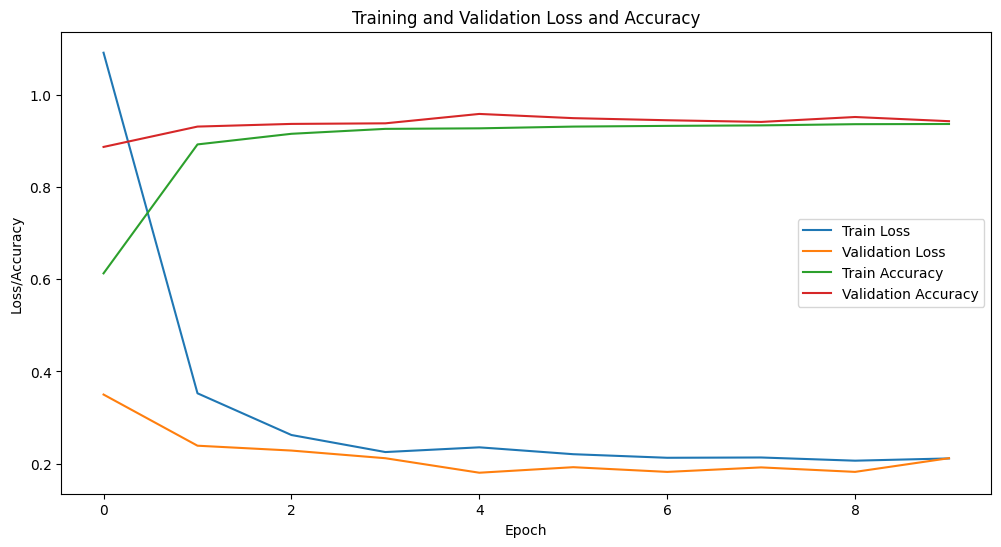

In [11]:

# Print classification report
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq_labels
print(classification_report(y_true_classes, y_pred_classes))

# confusion matrics
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)

#plot the validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')   
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()



In [13]:
# Calculate FPR and FNR
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq_labels
cm = confusion_matrix(y_true_classes, y_pred_classes)

# For multi-class, calculate FNR and FPR per class
fnr = []
fpr = []
for i in range(cm.shape[0]):
	fn = cm[i, :].sum() - cm[i, i]
	tp = cm[i, i]
	fp = cm[:, i].sum() - cm[i, i]
	tn = cm.sum() - (tp + fn + fp)
	fnr.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
	fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)

print("False Negative Rate (FNR) per class:", fnr)
print("False Positive Rate (FPR) per class:", fpr)

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step
False Negative Rate (FNR) per class: [np.float64(0.0), np.float64(0.03851925962981491), np.float64(0.032), np.float64(0.04351087771942986), np.float64(0.1722488038277512), np.float64(0.05025753863079462), np.float64(0.01025512756378189), np.float64(0.004001000250062516), np.float64(0.025506376594148537)]
False Positive Rate (FPR) per class: [np.float64(0.001057095007898519), np.float64(0.0052974154313949065), np.float64(0.009989309894286733), np.float64(0.004608568611846872), np.float64(0.00916106886714177), np.float64(0.005071101812120997), np.float64(0.0031238122386925125), np.float64(0.002672494684705016), np.float64(0.005523155681723699)]


In [15]:
import pandas as pd

# Use type_encoder.classes_ to match the order and number of classes
results_df = pd.DataFrame({
    "Class": type_encoder.classes_,
    "FNR": fnr,
    "FPR": fpr
})

print(results_df.to_string(index=False))


    Class      FNR      FPR
 backdoor 0.000000 0.001057
     ddos 0.038519 0.005297
      dos 0.032000 0.009989
injection 0.043511 0.004609
     mitm 0.172249 0.009161
   normal 0.050258 0.005071
 password 0.010255 0.003124
 scanning 0.004001 0.002672
      xss 0.025506 0.005523
